# Training Encoder decoder lstm with Method 2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [ ]:
# get data
df= pd.read_csv("/content/drive/MyDrive/ML/rnn/Machine_Translation/Data/cleaned.csv")

In [ ]:
df.tail()

,English,Marathi
41023,just saying you do not like fish because of th...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...
41024,the japanese parliament today officially elect...,आज जपानी संसदेने अधिकृतरित्या र्‍यौतारौ हाशिमो...
41025,tom tried to sell his old vcr instead of throw...,टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी व...
41026,you cannot view flash content on an ipad howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या...
41027,in roger miller recorded a song called you do...,मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावा...


This data is cleaned in notebook of [EDA](https://github.com/AdiShirsath/Neural-Machine-Translation/blob/master/EDA_And_Cleaning_Text.ipynb)

#### First most important thing is we have to add special tokens in each target language at start SOS and EOS at end reason of this is The length of translated sentence might not be same as other language so it is to tell model where is start and end of sentence.

In [ ]:
df.Marathi = df.Marathi.apply(lambda x: 'sos '+ x +' eos')

In [ ]:
# get english and marathi in one list
eng_texts = df.English.to_list()
mar_texts = df.Marathi.to_list()

## Tokenizer
Deep learning NN's does not accept text so first have to convert them into numbers 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def tokenize_sent(text):
  '''
  Take list on texts as input and 
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)



In [ ]:
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

In [ ]:
eng_encoded[100:105]

[[1, 26, 1541], [18, 3, 591], [18, 3, 21], [18, 3, 21], [21, 130]]

In [ ]:
eng_index_word = eng_tokenizer.index_word

In [ ]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

5641

In [ ]:
mar_encoded[30000:30005]

[[1, 190, 17, 2954, 45, 2],
 [1, 10307, 10308, 5956, 381, 150, 2],
 [1, 80, 986, 13, 46, 51, 217, 2],
 [1, 121, 52, 187, 260, 596, 2],
 [1, 40, 52, 187, 260, 596, 2]]

In [ ]:
mar_index_word= mar_tokenizer.index_word

In [ ]:
mar_word_index =mar_tokenizer.word_index

In [ ]:
MAR_VOCAB_SIZE=len(mar_tokenizer.word_counts)+1
MAR_VOCAB_SIZE

13720

In [ ]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
  if len(eng_encoded[i]) > max_mar_len:
    max_mar_len= len(mar_encoded[i])


In [ ]:
print(max_eng_len)
max_mar_len

36


37

## Padding 
We can not sent sentences with different length in neural net so padd them with zero 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Use max length for padding for eng and marathi
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')


In [ ]:
eng_padded.shape

(41028, 36)

In [ ]:
mar_padded.shape

(41028, 37)

In [ ]:
# Convert them into array
eng_padded= np.array(eng_padded)
mar_padded= np.array(mar_padded)

### Split into train and test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.1, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36925, 36), (4103, 36), (36925, 37), (4103, 37))

## Model

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional, Add, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [ ]:
# Eoncoder
encoder_input = Input(shape=(None, ))
encoder_embd = Embedding(ENG_VOCAB_SIZE,512, mask_zero=True)(encoder_input)
encoder_lstm = Bidirectional(LSTM(256, return_state=True))
encoder_output, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder_lstm(encoder_embd)
state_h_final = Concatenate()([forw_state_h, back_state_h])
state_c_final = Concatenate()([forw_state_c, back_state_c])

## Now take only states and create context vector
encoder_states= [state_h_final, state_c_final]

# Decoder
decoder_input = Input(shape=(None,))
# For zero padding we have added +1 in marathi vocab size
decoder_embd = Embedding(MAR_VOCAB_SIZE, 512, mask_zero=True)
decoder_embedding= decoder_embd(decoder_input)
# We used bidirectional layer above so we have to double units of this lstm
decoder_lstm = LSTM(512, return_state=True,return_sequences=True )
# just take output of this decoder dont need self states
decoder_outputs, _, _= decoder_lstm(decoder_embedding, initial_state=encoder_states)
# here this is going to predicct so we can add dense layer here
# here we want to convert predicted numbers into probability so use softmax
decoder_dense= Dense(MAR_VOCAB_SIZE, activation='softmax')
# We will again feed predicted output into decoder to predict its next word
decoder_outputs = decoder_dense(decoder_outputs)

model5 = Model([encoder_input, decoder_input], decoder_outputs)

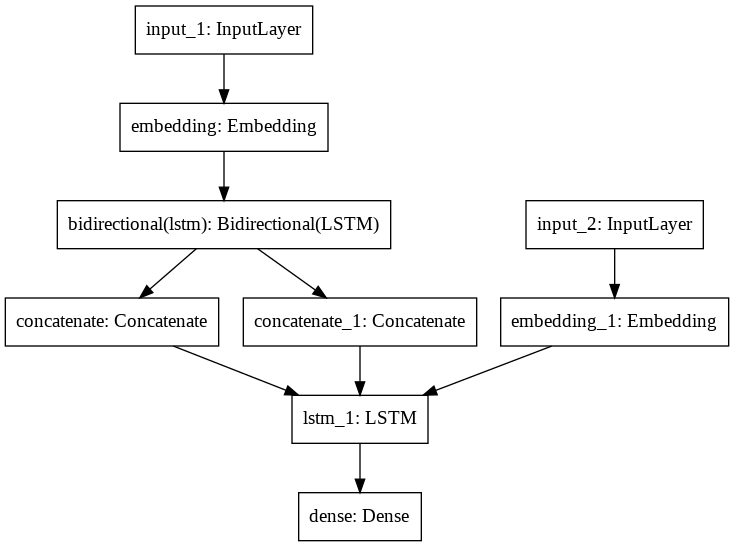

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model5)

In [ ]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2888192     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 1574912     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
y_train

array([[   1,   13,  445, ...,    0,    0,    0],
       [   1,   14,   20, ...,    0,    0,    0],
       [   1,    4,  109, ...,    0,    0,    0],
       ...,
       [   1,   23,  257, ...,    0,    0,    0],
       [   1,  170, 1575, ...,    0,    0,    0],
       [   1,   14, 1033, ...,    0,    0,    0]], dtype=int32)

In [ ]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2888192     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 1574912     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/", monitor='val_accuracy')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
EPOCHS= 50 #@param {type:'slider',min:10,max:100, step:10 }

### Prepare input for encoder -decoder model

In [ ]:
# Training
encoder_input_data = X_train
decoder_input_data = y_train[:,:-1]
decoder_target_data = y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test= y_test[:,1:]

In [ ]:
history = model5.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test ),
                     callbacks= callbacks_list)

Epoch 1/50
289/289 [==============================] - 61s 179ms/step - loss: 0.9475 - accuracy: 0.3151 - val_loss: 0.8124 - val_accuracy: 0.3692


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 2/50
289/289 [==============================] - 49s 170ms/step - loss: 0.7049 - accuracy: 0.4203 - val_loss: 0.6469 - val_accuracy: 0.4628


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 3/50
289/289 [==============================] - 49s 170ms/step - loss: 0.5364 - accuracy: 0.5109 - val_loss: 0.5290 - val_accuracy: 0.5329


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 4/50
289/289 [==============================] - 49s 169ms/step - loss: 0.4005 - accuracy: 0.5909 - val_loss: 0.4501 - val_accuracy: 0.5879


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 5/50
289/289 [==============================] - 49s 170ms/step - loss: 0.2956 - accuracy: 0.6664 - val_loss: 0.4004 - val_accuracy: 0.6280


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 6/50
289/289 [==============================] - 49s 169ms/step - loss: 0.2185 - accuracy: 0.7310 - val_loss: 0.3701 - val_accuracy: 0.6590


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 7/50
289/289 [==============================] - 49s 168ms/step - loss: 0.1634 - accuracy: 0.7872 - val_loss: 0.3513 - val_accuracy: 0.6776


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 8/50
289/289 [==============================] - 49s 170ms/step - loss: 0.1251 - accuracy: 0.8292 - val_loss: 0.3417 - val_accuracy: 0.6888


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 9/50
289/289 [==============================] - 49s 170ms/step - loss: 0.0993 - accuracy: 0.8584 - val_loss: 0.3358 - val_accuracy: 0.6976


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 10/50
289/289 [==============================] - 49s 170ms/step - loss: 0.0811 - accuracy: 0.8786 - val_loss: 0.3327 - val_accuracy: 0.7063


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 11/50
289/289 [==============================] - 49s 170ms/step - loss: 0.0682 - accuracy: 0.8931 - val_loss: 0.3326 - val_accuracy: 0.7114


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 12/50
289/289 [==============================] - 49s 170ms/step - loss: 0.0587 - accuracy: 0.9030 - val_loss: 0.3335 - val_accuracy: 0.7133


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 13/50
289/289 [==============================] - 49s 170ms/step - loss: 0.0521 - accuracy: 0.9098 - val_loss: 0.3337 - val_accuracy: 0.7160


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 14/50
289/289 [==============================] - 49s 170ms/step - loss: 0.0469 - accuracy: 0.9160 - val_loss: 0.3366 - val_accuracy: 0.7167


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 15/50
289/289 [==============================] - 49s 169ms/step - loss: 0.0432 - accuracy: 0.9195 - val_loss: 0.3400 - val_accuracy: 0.7172


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 16/50
289/289 [==============================] - 49s 169ms/step - loss: 0.0405 - accuracy: 0.9223 - val_loss: 0.3397 - val_accuracy: 0.7177


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 17/50
289/289 [==============================] - 50s 174ms/step - loss: 0.0382 - accuracy: 0.9241 - val_loss: 0.3426 - val_accuracy: 0.7191


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 18/50
289/289 [==============================] - 50s 172ms/step - loss: 0.0366 - accuracy: 0.9258 - val_loss: 0.3448 - val_accuracy: 0.7184


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 19/50
289/289 [==============================] - 50s 173ms/step - loss: 0.0355 - accuracy: 0.9268 - val_loss: 0.3471 - val_accuracy: 0.7170


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 20/50
289/289 [==============================] - 50s 173ms/step - loss: 0.0347 - accuracy: 0.9268 - val_loss: 0.3494 - val_accuracy: 0.7170


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 21/50
289/289 [==============================] - 50s 173ms/step - loss: 0.0339 - accuracy: 0.9276 - val_loss: 0.3524 - val_accuracy: 0.7149


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


Epoch 22/50
289/289 [==============================] - 50s 172ms/step - loss: 0.0333 - accuracy: 0.9277 - val_loss: 0.3523 - val_accuracy: 0.7173


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/model_checkpoints/model5/assets


In [ ]:
model5.save_weights("/content/drive/MyDrive/ML/rnn/Machine_Translation/Encoder_decoder/saved_models/model5")

# inference Model

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Input, Model

In [ ]:
encoder_model = Model(encoder_input, encoder_states)

In [ ]:
decoder_state_input_h = Input(shape=(512,))
decoder_state_input_c= Input(shape=(512,))
decoder_states_input= [decoder_state_input_h, decoder_state_input_c]

dec_embd2 = decoder_embd(decoder_input)

decoder_output2,state_h2, state_c2 = decoder_lstm(dec_embd2, initial_state=decoder_states_input)
deccoder_states2= [state_h2, state_c2]

decoder_output2 = decoder_dense(decoder_output2)

decoder_model = Model(
                      [decoder_input]+decoder_states_input,
                      [decoder_output2]+ deccoder_states2)

#### Converting predicted numbers into text

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences

    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index==0:
          break
        else:   
         # convert max index number to marathi word
         sampled_char = mar_index_word[sampled_token_index]
        # aapend it ti decoded sent
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence) >= 37):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
def get_marathi_sentence(sequence):
  sentence=""
  for i in sequence:
    if ((i != 0 and i != mar_word_index['sos']) and i != mar_word_index['eos']):
      sentence = sentence + mar_index_word[i]+' '
  return sentence

def get_eng_sent(sequence):
    sentence =''
    for i in sequence:
      if(i!=0):
        sentence = sentence + eng_index_word[i]+' '
    return sentence       

In [ ]:
for i in range(20):
  print("English sentence:",get_eng_sent(X_test[i]))
  print("Actual Marathi Sentence:",get_marathi_sentence(y_test[i]))
  print("Translated Marathi Sentence:",get_predicted_sentence(X_test[i].reshape(1,36))[:-4])
  print("\n")

English sentence: i was calling my friend 
Actual Marathi Sentence: मी माझ्या मित्राला बोलवत होतो 
Translated Marathi Sentence:  मी माझ्या मैत्रिणीला फोन करत होते


English sentence: i like coffee 
Actual Marathi Sentence: मला कॉफी आवडते 
Translated Marathi Sentence:  मला कॉफी आवडते


English sentence: you cannot view flash content on an ipad however you can easily email yourself the urls of these web pages and view that content on your regular computer when you get home 
Actual Marathi Sentence: आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या वेब पानांचे यूआरएल स्वतःला ईमेल करून तोच आशय घरी पोहोचल्यावर आपल्या रोजच्या संगणकावर पाहू शकता 
Translated Marathi Sentence:  जर तू भारतापासून शहर रेकॉर्ड करू


English sentence: he likes english very much 
Actual Marathi Sentence: त्यांना इंग्रजी खूप आवडते 
Translated Marathi Sentence:  त्याला इंग्रजी खूप आवडते


English sentence: i do not like shopping with you 
Actual Marathi Sentence: मला तुझ्याबरोबर शॉपिंग करायला आवडत नाही 
Translated Marathi